# Getting started with Deltaflow

This notebook will take you through the creation of a simple Deltaflow program and explain the core concepts along the way.

### Terminology

Dataflow programming is the core concept behind Deltaflow. We split this paradigm into three parts:

1. **Block definition**. A _block_ is a contiguous piece of code that can run indepndent of any other code. In theory, blocks can be written in any language. Currently we are using Python as a demonstration language.

2. **Node connectivity**. Also called the "wiring". A node is an object that is responsible for running a single block by collecting input values from, and sending output values to, connected nodes. We call a collection of connected nodes a DeltaGraph. You can think of this as a directed graph where edges show the transition of data and vertices represent operations on said data.

3. **Runtime**. This is where a DeltaGraph is executed. A _runtime_ is responsible for taking DeltaGraphs and running them on some target architecture/configuration. A DeltaGraph is largely platform agnostic, with dedicated runtimes being written for each target platform.

## Example code

We start by importing a few objects and types.

In [1]:
from deltalanguage.data_types import NoMessage
from deltalanguage.lib.primitives import StateSaver
from deltalanguage.runtime import DeltaPySimulator, DeltaRuntimeExit
from deltalanguage.wiring import DeltaBlock, DeltaGraph

To define a block for use in the Deltaflow system we write a normal Python function and add the `@DeltaBlock` decorator. This function has several optional arguments. It is necessary for users to specify the type annotation of arguments and returns in the function signature; Python does not enforce function/variable type annotations in general, but in Deltaflow specifying them is mandatory.

To see more about the types you can use, see this notebook: [data_types](data_types.ipynb).

**Tip**: name is an optional keyword argument for the `DeltaBlock` decorator that allows us to set the name of nodes created using this block.

In [2]:
@DeltaBlock(name="add")
def add(a: int, b: int) -> int:
    return a + b

This decorated function can still be used as normal when we don't try to put it into a `DeltaGraph`. This is useful for integrating Deltaflow with existing systems or testing.

In [3]:
x = add(4, 3)

print(x)

assert x == 7

7


To create a node that will represent this block in a `DeltaGraph`, you can use the provided factories or our `with` syntax. This example will use the latter.

In [4]:
with DeltaGraph() as graph_1:
    in_graph_block = add(a=4, b=3)

print(in_graph_block)

add_2:
    in : (a, DInt32, 0, False)
    in : (b, DInt32, 0, False)



We can see that when we call the add function into our `DeltaGraph` context, it no longer executes normally. Instead, calling the decorated function has created and returned a node.

This node has also been added to our graph for us, as can be seen by printing the graph.

In [5]:
print(graph_1)

DeltaGraph[main] {
    node_0:
        out: (add_2.a, DInt32)
    node_1:
        out: (add_2.b, DInt32)
    add_2:
        in : (a, DInt32, 0, False)
        in : (b, DInt32, 0, False)
}



Somewhat surprisingly, we see 3 nodes in our graph. This is because the arguments we gave our `add` function also need to become nodes on the `DeltaGraph`. These two created nodes have very simple, automatically constructed, blocks. The blocks just return the value we want to supply to add.

Knowing to send data from one node to another requires an edge to be created in our `DeltaGraph`. On the printed format of the graph we can see two edges have been added going into our add node, one from each of it's created argument nodes.

There is no output for `graph_1`, so let's define another block so we can make a graph where our `add` node can send its result to be printed.

In [6]:
s = StateSaver(verbose=True)

with DeltaGraph() as graph_2:
    added = add(a=4, b=3)
    s.save_and_exit(added)

print(graph_2)

DeltaGraph[main] {
    node_3:
        out: (add_5.a, DInt32)
    node_4:
        out: (add_5.b, DInt32)
    add_5:
        in : (a, DInt32, 0, False)
        in : (b, DInt32, 0, False)
        out: (save_and_exit_6.val, DInt32)
    save_and_exit_6:
        in : (val, T, 0, False)
}



This graph now has an additional edge from our `add` node to the `save_and_exit` node.

We can also create visual representations of our graph using the draw method. This method uses the [NetworkX](https://networkx.org/) library to draw a graph.

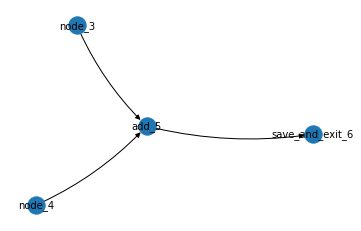

In [7]:
graph_2.draw(seed=1)

See [draw_networkx](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx) for details on what parameters can be passed to draw.

Note: NetworkX has limited drawing functionality and might not be suitable for visualising more complicated Deltaflow graphs. To visualise more complex graphs, it is recommended to use `graph.write_gml(path)`, which saves a GraphML file in the location specified by path. This file can then be imported to more powerful graph visualisation tools such as [Cytoscape](https://cytoscape.org/). See the [NetworkX](https://networkx.github.io/documentation/stable/reference/drawing.html) documentation for further details.

To run a graph we need a runtime, which takes a graph in its constructor. We can then call run on this runtime to execute our graph.

In [9]:
s.reset()

rt = DeltaPySimulator(graph_2)
rt.run()

assert s.saved == [7]

saving 7


During the execution of `graph_2`, once both of the argument nodes have output their data, the `add` node will call our `add` block using the received data for its arguments. The `add` node then gets the return value from the `add` block and will pass it on to the `save_and_exit` node. This node will save its input within `s.saved` and then raise a `DeltaRuntimeExit` exception, which will cause the runtime to terminate.

Note: Raising a `DeltaRuntimeExit` exception is currently the correct way to terminate the execution of a graph. Execution termination is managed by the runtime, raising this exception is just a way to signal to the runtime that execution should stop.